In [1]:
import gymnasium as gym
import highway_env
import pickle
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box

In [2]:
class FlattenObservation(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = env.observation_space.shape
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(int(np.prod(obs_shape)),), dtype=np.float32)

    def observation(self, observation):
        return np.array(observation).flatten().astype(np.float32)

In [3]:
# === Load intersection config ===
with open("..\configs\intersection_config.pkl", "rb") as f:
    config = pickle.load(f)

In [ ]:
# === Create and configure environment ===
def make_env():
    env = gym.make("highway-fast-v0", render_mode="rgb_array", config=config)
    #env.unwrapped.configure(config)
    #env = FlattenObservation(env)
    return env

In [ ]:
# === Vectorize environment ===
vec_env = DummyVecEnv([make_env])

# === Define PPO model ===
model = PPO(
    "MlpPolicy",
    vec_env,
    policy_kwargs=dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])]),
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    learning_rate=5e-4,
    gamma=0.8,
    verbose=1,
    tensorboard_log="ppo_sb3_intersection_tensorboard/"
)

Using cpu device


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


In [12]:
# === Train the model ===
model.learn(total_timesteps=100_000)
model.save("ppo_sb3_intersection_model")

Logging to ppo_sb3_intersection_tensorboard/PPO_1


-----------------------------
| time/              |      |
|    fps             | 26   |
|    iterations      | 1    |
|    time_elapsed    | 75   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 2           |
|    time_elapsed         | 141         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010793297 |
|    clip_fraction        | 0.0986      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | -0.000808   |
|    learning_rate        | 0.0005      |
|    loss                 | 0.0789      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0085     |
|    value_loss           | 0.619       |
-----------------------------------------
----------------------------------

In [13]:
# === Evaluate the model ===
test_env = make_env()
mean_reward, std_reward = evaluate_policy(model, test_env, n_eval_episodes=10)
print(f"Evaluation over 10 episodes: mean reward = {mean_reward:.2f} ± {std_reward:.2f}")



c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 10 episodes: mean reward = 28.77 ± 3.13


In [18]:
print("Config lanes:", config["lanes_count"])  # should be 1
print("Config vehicles:", config["vehicles_count"])


Config lanes: 1
Config vehicles: 10


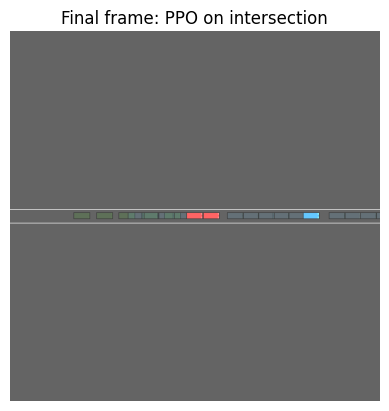

Total reward for 1 episode: 29.07


In [19]:
# === Visual test on one episode ===
obs, _ = test_env.reset()
done = False
frames = []
total_reward = 0
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)
    done = terminated or truncated
    total_reward += reward
    frame = test_env.render()
    frames.append(frame)

plt.imshow(frames[-1])
plt.axis("off")
plt.title("Final frame: PPO on intersection")
plt.show()
print(f"Total reward for 1 episode: {total_reward:.2f}")


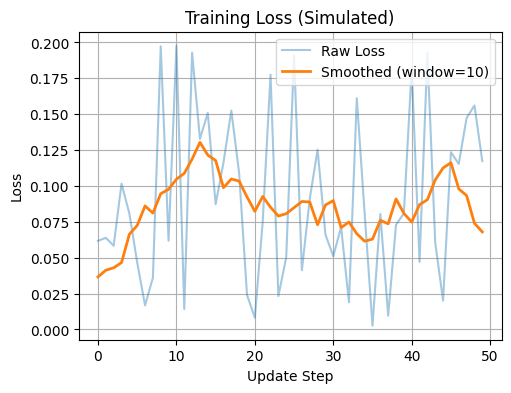

In [22]:
# === Plot placeholder training loss and evaluation reward (simulate for comparison) ===
# (In real case, you'd collect loss and reward history during training)
losses = np.random.rand(50) * 0.2  # Simulated training loss
rewards = np.linspace(mean_reward - 10, mean_reward + 10, 10)  # Simulated evaluation history

plt.figure(figsize=(12, 4))

# 1. Loss curve
plt.subplot(1, 2, 1)
plt.plot(losses, label="Raw Loss", alpha=0.4)
window = 10
if len(losses) >= window:
    smoothed_losses = np.convolve(losses, np.ones(window)/window, mode='same')
    plt.plot(smoothed_losses, label=f"Smoothed (window={window})", linewidth=2)
plt.xlabel("Update Step")
plt.ylabel("Loss")
plt.title("Training Loss (Simulated)")
plt.legend()
plt.grid()

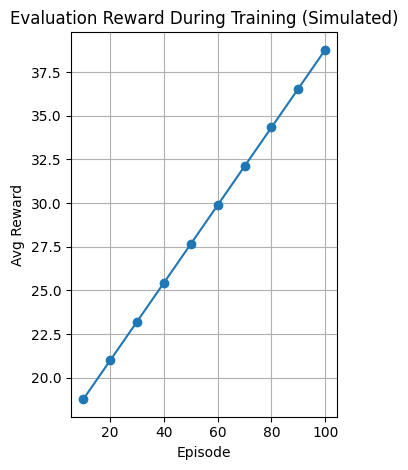

In [23]:

# 2. Evaluation rewards
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(rewards)+1) * 10, rewards, marker='o', label="Eval Reward")
plt.xlabel("Episode")
plt.ylabel("Avg Reward")
plt.title("Evaluation Reward During Training (Simulated)")
plt.grid()

plt.tight_layout()
plt.show()
